In [1]:
import numpy as np
from feos_pcsaft.si import *
from feos_pcsaft import *
from feos_pcsaft.eos import *
from feos_pcsaft.dft import *


import matplotlib.pyplot as plt

In [2]:
feos_pcsaft.__file__

'/usr/ITT/bursik/promotion/code/feos/feos-pcsaft/venv/lib/python3.8/site-packages/feos_pcsaft/feos_pcsaft.abi3.so'

# Local DFT Implementation

In [3]:
components = ['hexane']
temperature = 298.15* KELVIN
pressure = 1 * BAR

In [4]:
params = PcSaftParameters.from_json(components, '20191105_pure_parameters.json')
func = PcSaftFunctional(params)
func_hs = (params)

In [15]:
vle = PhaseEquilibrium.pure_t(func, temperature)
t_crit = State.critical_point_pure(func)[0].temperature

In [16]:
solver = DFTSolver().anderson_mixing(tol=1.0e-9,mmax=10)#.picard_iteration(tol=1.0e-5) # just write after one another
interface = PlanarInterface.from_tanh(vle, 1024, 50 * ANGSTROM, t_crit)

In [41]:
interface.functional_derivative

array([[ 4.25951681,  4.25951682,  4.25951683, ..., 25.11082228,
        25.11082207, 25.11082196]])

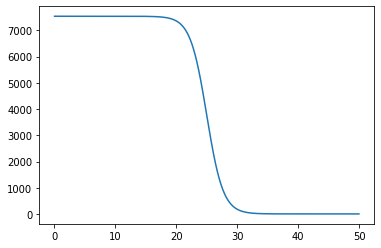

In [19]:
# plot initial density profile
plt.plot(interface.z / ANGSTROM, (interface.density / MOL * METER**3)[0,:])
#plt.plot(interface.z / ANGSTROM, (interface.density / MOL * METER**3)[1,:])

In [38]:
wd = interface.weighted_densities
#plt.plot(interface.z / ANGSTROM, (wd / MOL * METER**3)[0,:])
print(len(wd))
print(wd[1].shape)

3
(3, 1024)


## DFT Example

In [8]:
## Planar Interface 

In [9]:
# system specification
components = ['hexane', 'octane'] # ['hexane'] # 
x = 0.3
composition = np.array([x, 1-x])
temperature = 298.15* KELVIN
pressure = 1 * BAR

In [10]:
# Read Parameters
params = PcSaftParameters.from_json(components, '20191105_pure_parameters.json')

In [11]:
# Create Functional based on parameters
func = PcSaftFunctional(params)

In [12]:
# calculate phase equilibrium
#vle = PhaseEquilibrium.pure_t(func, temperature)
vle = PhaseEquilibrium.bubble_point_tx(func, temperature, composition)
vle


||temperature|density|molefracs|
|-|-|-|-|
|phase 1|298.15 K|2.964357865432749  mol/m³|[0.81911, 0.18089]|
|phase 2|298.15 K|6.446506873296946 kmol/m³|[0.30000, 0.70000]|


In [13]:
# calculate critical point (needed for initializiation of tanh profile)
#t_crit = State.critical_point_pure(func)[0].temperature
t_crit = State.critical_point(func, 1 * MOL *composition).temperature
t_crit

568.0769398960161 K

In [14]:
# intialize solver and interface density profile
solver = DFTSolver().anderson_mixing(tol=1.0e-9,mmax=10)#.picard_iteration(tol=1.0e-5) # just write after one another
interface = PlanarInterface.from_tanh(vle, 1024, 50 * ANGSTROM, t_crit)

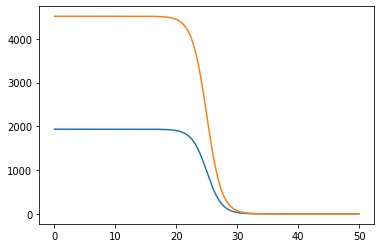

In [15]:
# plot initial density profile
plt.plot(interface.z / ANGSTROM, (interface.density / MOL * METER**3)[0,:])
plt.plot(interface.z / ANGSTROM, (interface.density / MOL * METER**3)[1,:])

In [16]:
# solve DFT
interface.solve(solver)

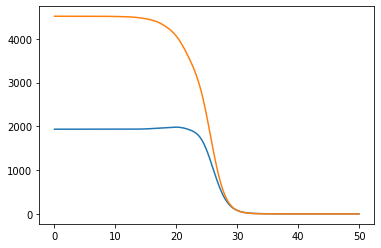

In [17]:
# plot final density profile
plt.plot(interface.z / ANGSTROM, (interface.density / MOL * METER**3)[0,:])
plt.plot(interface.z / ANGSTROM, (interface.density / MOL * METER**3)[1,:])

In [18]:
# print surface tension
interface.surface_tension

20.139265293913347 mN/m

In [19]:
interface.equimolar_radius

2.4999964243534305 nm

# Adsorption at a wall in 1D

In [20]:
# system specification
components =  ['butane']
composition = np.array([x, 1-x])
temperature = 250.15* KELVIN
pressure = 1 * BAR

In [21]:
# Read Parameters
params = PcSaftParameters.from_json(components, '20191105_pure_parameters.json')

In [22]:
# Create Functional based on parameters
func = PcSaftFunctional(params)

In [23]:
# Create State 
state = State(func, temperature, pressure=pressure)

In [24]:
# create potential 
#potential  = ExternalPotential.LJ93(3.0, 250.0, 0.08)
potential  = ExternalPotential.HardWall(3.1)


In [28]:
# Create wall as a cartesian (slit) pore with large width --> bulk in the center
wall_profile = Pore1D(func, Geometry.Cartesian, pore_size= 50*ANGSTROM, potential = potential).initialize(state)

In [29]:
# set solver
solver = DFTSolver(output=True).picard_iteration(tol=1.0e-6, max_iter=1000).anderson_mixing(tol=1.0e-8, max_iter=500, mmax=10)

In [ ]:
# solve DFT for wall 
wall_profile.solve(solver)

In [ ]:
# plot resulting density profile
plt.plot(wall_profile.z/ANGSTROM, (wall_profile.density/MOL*METER**3)[0,:])

In [ ]:
wall_profile.density/MOL*METER**3